#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Задача: 
- Построить модель для такого предсказания
- Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План работы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


In [1]:
!pip install -U scikit-learn -q

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

## Подготовка

In [3]:
df = pd.read_csv('...', index_col=[0], parse_dates=[0])

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.isna().sum()

num_orders    0
dtype: int64

In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
#проверим индекс на монотонность
df.index.is_monotonic

True

In [9]:
#ресемплируем данные по 1 часу
df = df.resample('1H').sum()

В нашем файле данные по заказам такси с марта по август 2018 года. В первом шаге установили даты в качестве индекса таблицы. Данные были проверены на наличие пропусков и монотонность, а затем выполнено ресемплирование по часу (изначально данные представлены с интервалом в 10 минут).

## Анализ

In [10]:
#функция для построения графиков
sns.set(rc={'figure.figsize':(12,8)})

def lineplot(df, title):
    df.plot()
    plt.title(title)
    plt.show()

In [11]:
#hазделим данные на трендовую, сезонную и шумовую состовляющие
decomposed = seasonal_decompose(df)

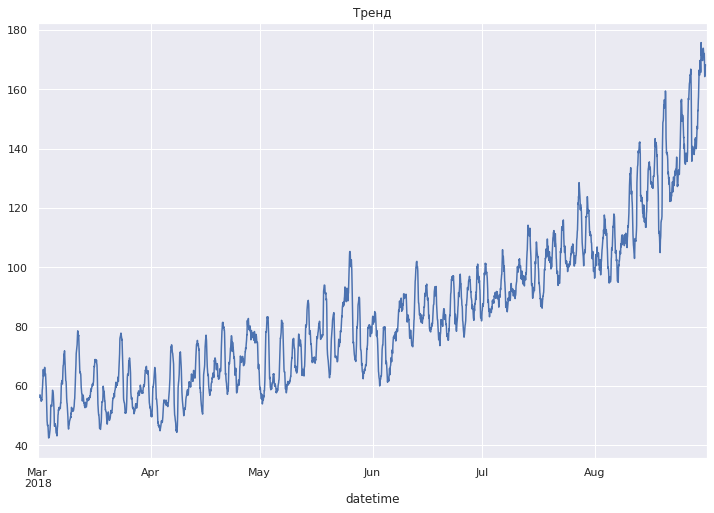

In [12]:
lineplot(decomposed.trend, 'Тренд')

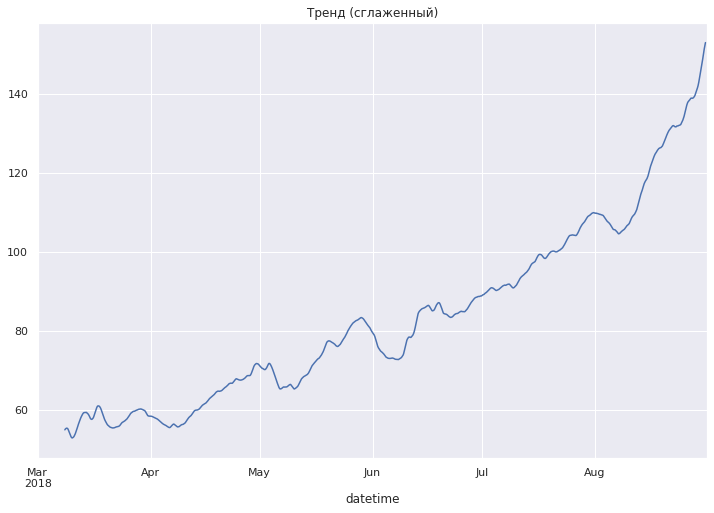

In [13]:
lineplot(decomposed.trend.rolling(24*7).mean(), 'Тренд (сглаженный)')

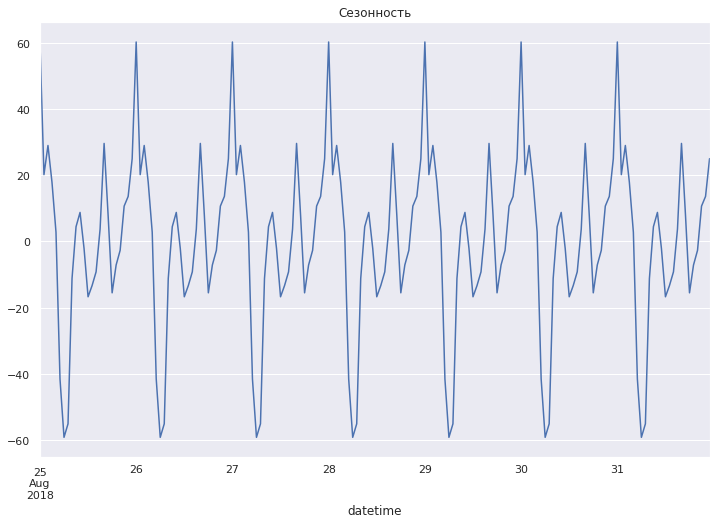

In [14]:
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')

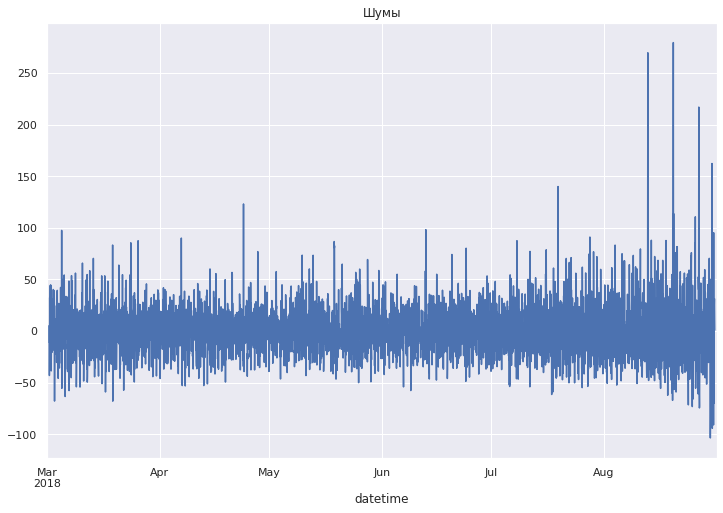

In [15]:
lineplot(decomposed.resid, 'Шумы')

Наблюдается тренд равномерного роста заказов с периодическими небольшими падениями
Присутствует сезонность по дням - спад ночью, рост с утра и днем, пик к вечеру

### Подготовка признаков

In [16]:
#функция создания признаков для горизонта прогнозирования на 1 шаг
def get_features(df, max_lag, rolling_mean_size):
    #создаем копию входного DataFrame
    df_copy = df.copy()
    
    #добавление признаков месяца, дня, дня недели и часа
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['hour'] = df_copy.index.hour
    
    #вычисление отстающих признаков с шагом от 1 до max_lag
    for lag in range(1, max_lag + 1):
        df_copy[f'lag_{lag}'] = df_copy['num_orders'].shift(lag)
    
    #вычисление скользящего среднего с заданным окном rolling_mean_size
    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    #возвращаем новый DataFrame с добавленными признаками
    return df_copy

#применение функции с max_lag = 24 и размером окна скользящего среднего = 10
df_1 = get_features(df, max_lag=24, rolling_mean_size=10)

df_1.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_1.shape

(4392, 30)

In [25]:
#удалим пропуски
df_1.dropna(inplace=True)

In [26]:
df_1.shape

(4392, 30)

In [27]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   month         4392 non-null   int64  
 2   day           4392 non-null   int64  
 3   dayofweek     4392 non-null   int64  
 4   hour          4392 non-null   int64  
 5   lag_1         4392 non-null   float64
 6   lag_2         4392 non-null   float64
 7   lag_3         4392 non-null   float64
 8   lag_4         4392 non-null   float64
 9   lag_5         4392 non-null   float64
 10  lag_6         4392 non-null   float64
 11  lag_7         4392 non-null   float64
 12  lag_8         4392 non-null   float64
 13  lag_9         4392 non-null   float64
 14  lag_10        4392 non-null   float64
 15  lag_11        4392 non-null   float64
 16  lag_12        4392 non-null   float64
 17  lag_13        4392 non-null

## Обучение

In [28]:
#определение признаков и целевой переменной
features = df_1.drop(columns='num_orders')
target = df_1['num_orders']

#разделение данных на обучающую и тестовую выборки (без перемешивания)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False, random_state=42)

In [29]:
tscv = TimeSeriesSplit(n_splits=2)

### LinearRegression

In [30]:
model_lr = LinearRegression()
 
model_lr.fit(features_train, target_train)

rmse_lr = -cross_val_score(model_lr, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
print(f'RMSE для LinearRegression: {rmse_lr}')

RMSE для LinearRegression: 27.96424679977411


### CatBoostRegressor

In [31]:
model_catboost = CatBoostRegressor(verbose=False)
model_catboost.fit(features_train, target_train, verbose=False)
rmse_cat = -cross_val_score(model_catboost, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
print(f'RMSE для CatBoostRegressor: {rmse_cat}')

RMSE для CatBoostRegressor: 27.2602697784843


### RandomForestRegressor

In [32]:
model_rfr = RandomForestRegressor(random_state=42)
parameters = {
    'n_estimators':range(50,100,10), 
    'max_depth':range(1,11,2)
}

gsearch = GridSearchCV(estimator=model_rfr, cv=tscv, param_grid=parameters, scoring='neg_root_mean_squared_error')
gsearch.fit(features_train, target_train)
best_params = gsearch.best_params_
rmse_rfr = -gsearch.best_score_
print(f'Лучшие параметры для RandomForestRegressor: {best_params}')
print(f'RMSE для RandomForestRegressor: {rmse_rfr}')

Лучшие параметры для RandomForestRegressor: {'max_depth': 9, 'n_estimators': 90}
RMSE для RandomForestRegressor: 27.876271735084714


### LGBMRegressor

In [34]:
model_lgb = lgb.LGBMRegressor()
model_lgb.fit(features_train, target_train, callbacks=[log_evaluation(0)])
rmse_lgb = -cross_val_score(model_lgb, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()
print(f'RMSE для LGBMRegressor: {rmse_lgb}')

RMSE для LGBMRegressor: 27.50974960800408


## Тестирование

Добавим расчеты RMSE в DataFrame с результатами и построим графики для исходных и предсказанных данных для каждой модели

In [35]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'CatBoostRegressor', 'RandomForestRegressor', 'LGBMRegressor'],
    'RMSE_train': [rmse_lr, rmse_cat, rmse_rfr, rmse_lgb]
})
display(results.sort_values(by='RMSE'))

,Model,RMSE_train
1,CatBoostRegressor,27.260270
3,LGBMRegressor,27.509750
2,RandomForestRegressor,27.876272
0,Linear Regression,27.964247


Лучшая модель - CatBoostRegressor, где rmse = 27.26, получим предсказания на тестовой выборке с использованием этой модели

In [36]:
#предсказания на тестовой выборке
predictions_test = model_catboost.predict(features_test)

#расчет RMSE
rmse_test_catboost = root_mean_squared_error(target_test, predictions_test)
print("\nRMSE CatBoostRegressor на тестовой выборке: %.2f" % rmse_test_catboost)


RMSE CatBoostRegressor на тестовой выборке: 39.73


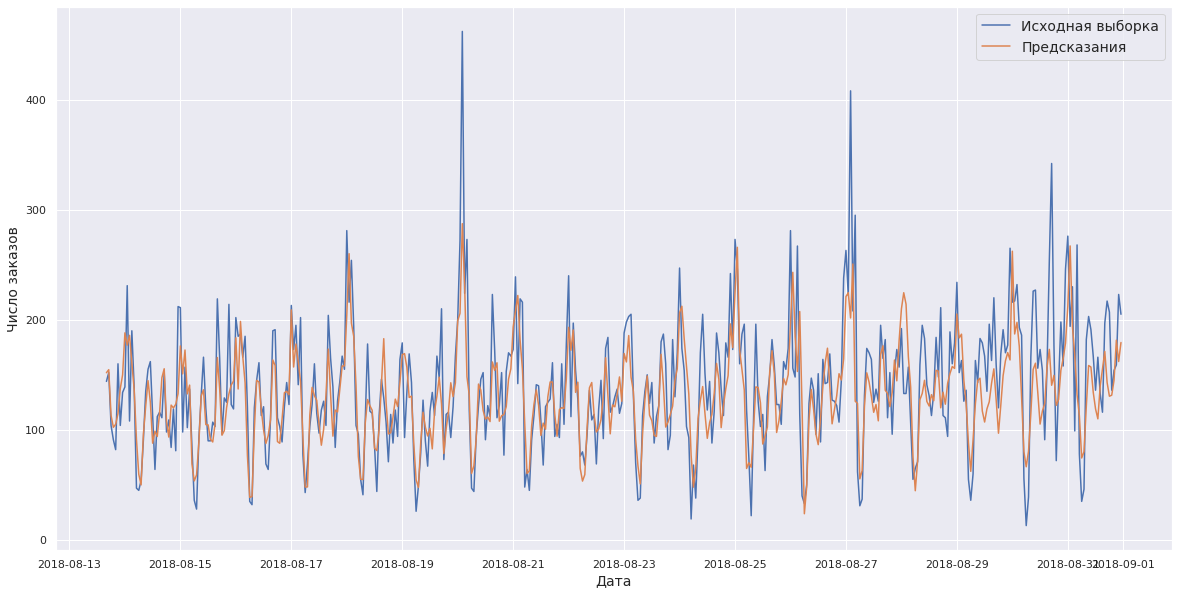

In [37]:
#построим график для исходных данных и для предсказанных
predictions_test = pd.Series(predictions_test, index=target_test.index)
plt.figure(figsize=(20,10))
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Число заказов',fontsize=14)
plt.plot(target_test, label='Исходная выборка')
plt.plot(predictions_test, label='Предсказания')
plt.legend(fontsize=14)
plt.show()

Вывод:
Показатель RMSE на тестовой выборке дал значение 39.73, что соответствует условию задачи. На графике видно, что модель предсказывает адекватно, но по всплескам видно, что она иногда ошибается.